# EDA

In [157]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from  nltk import FreqDist

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from mlxtend.feature_selection import ColumnSelector
from sklearn.feature_selection import chi2

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

from sklearn.model_selection import train_test_split
import re
import string

In [158]:
df = pd.read_pickle("../data/df.pkl")
df.head()

,Publication,Content,Bias
0,CNN,Istanbul (CNN) At least 39 people were killed ...,Left
1,CNN,Atlanta (CNN) This season’s College Football P...,Left
2,CNN,(CNN) Revelers on the United States’ west coa...,Left
3,CNN,"West Palm Beach, Florida (CNN) Donald Trump s...",Left
4,CNN,(CNN) Two small planes collided in Texas on S...,Left


In [159]:
df['word_count'] = df["Content"].apply(lambda x: len(nltk.word_tokenize(str(x))) )
df['char_count'] = df["Content"].apply(lambda x: sum(len(word) for word in nltk.word_tokenize(str(x))) )
df['sentence_count'] = df["Content"].apply(lambda x: len(nltk.sent_tokenize(str(x))) )

In [160]:
df["word_count"].describe()

count    85365.000000
mean       828.694980
std        928.792525
min          0.000000
25%        384.000000
50%        623.000000
75%        999.000000
max      31067.000000
Name: word_count, dtype: float64

<AxesSubplot:xlabel='word_count', ylabel='Count'>

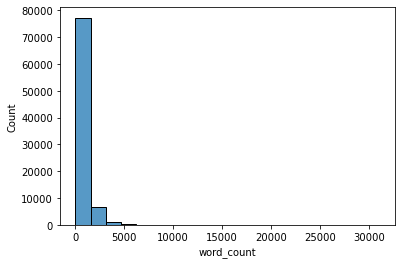

In [161]:
sns.histplot(data = df, x = "word_count", bins = 20)

In [162]:
df1 = df[df["word_count"]>5000]
df1.head()

,Publication,Content,Bias,word_count,char_count,sentence_count
229,CNN,(CNN) Barack Obama ends his two terms in the ...,Left,5938,25903,261
1137,CNN,PRESIDENT DONALD TRUMP HOLDS A NEWS CONFERENCE...,Left,17678,60902,1169
1422,CNN,PRESIDENT DONALD J. TRUMP’S ADDRESS TO A JOINT...,Left,5379,22801,258
2720,CNN,(CNN) The world was dumbfounded by the electi...,Left,5325,23029,209
3865,CNN,(CNN) Republican Rep. Mo Brooks called into C...,Left,8370,30741,460


In [163]:
df2 = df[df["word_count"]<5000]
df2.head()

,Publication,Content,Bias,word_count,char_count,sentence_count
0,CNN,Istanbul (CNN) At least 39 people were killed ...,Left,1096,4625,43
1,CNN,Atlanta (CNN) This season’s College Football P...,Left,1114,4334,61
2,CNN,(CNN) Revelers on the United States’ west coa...,Left,980,4225,38
3,CNN,"West Palm Beach, Florida (CNN) Donald Trump s...",Left,709,2959,25
4,CNN,(CNN) Two small planes collided in Texas on S...,Left,97,450,5


In [164]:
df2.describe()

,word_count,char_count,sentence_count
count,84885.000000,84885.000000,84885.000000
mean,780.788797,3356.648242,29.735949
std,613.962674,2601.814939,25.109396
min,0.000000,0.000000,0.000000
25%,382.000000,1642.000000,14.000000
50%,620.000000,2669.000000,23.000000
75%,991.000000,4316.000000,38.000000
max,4982.000000,23829.000000,388.000000


In [165]:
line = "This is going to be almost tweny-five words long by the time \
        I am done writing this very long and stupid run on sentance. \
        The next sentance will contain enough words to round out the total \
        count to almost as much as i need but not quite enough but now i do"
len(line.split())

52

In [166]:
df3 = df2[df2["word_count"] >50]
df3

,Publication,Content,Bias,word_count,char_count,sentence_count
0,CNN,Istanbul (CNN) At least 39 people were killed ...,Left,1096,4625,43
1,CNN,Atlanta (CNN) This season’s College Football P...,Left,1114,4334,61
2,CNN,(CNN) Revelers on the United States’ west coa...,Left,980,4225,38
3,CNN,"West Palm Beach, Florida (CNN) Donald Trump s...",Left,709,2959,25
4,CNN,(CNN) Two small planes collided in Texas on S...,Left,97,450,5
...,...,...,...,...,...,...
85360,National Review,I first read Thomas Sowell in college — no ...,Right,954,4175,40
85361,National Review,Whether it’s celebrated according to the Grego...,Right,1356,6284,30
85362,National Review,Editor’s Note: This piece first appeared in th...,Right,846,3202,31
85363,National Review,Israel would seem to be in a disastrous positi...,Right,905,4014,45


<AxesSubplot:xlabel='word_count', ylabel='Count'>

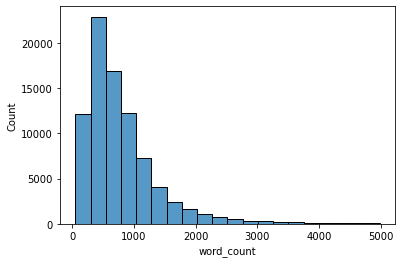

In [167]:
sns.histplot(data = df3, x = "word_count", bins = 20)

In [168]:
df = df[(df["word_count"]<5000) & (df["word_count"] >50)]
df.head()

,Publication,Content,Bias,word_count,char_count,sentence_count
0,CNN,Istanbul (CNN) At least 39 people were killed ...,Left,1096,4625,43
1,CNN,Atlanta (CNN) This season’s College Football P...,Left,1114,4334,61
2,CNN,(CNN) Revelers on the United States’ west coa...,Left,980,4225,38
3,CNN,"West Palm Beach, Florida (CNN) Donald Trump s...",Left,709,2959,25
4,CNN,(CNN) Two small planes collided in Texas on S...,Left,97,450,5


In [169]:
df.shape

(83524, 6)

In [170]:
df.isna().sum()

Publication       0
Content           0
Bias              0
word_count        0
char_count        0
sentence_count    0
dtype: int64

In [171]:
df.dropna(inplace=True)

In [172]:
df.isna().sum()

Publication       0
Content           0
Bias              0
word_count        0
char_count        0
sentence_count    0
dtype: int64

In [173]:
df.info

<bound method DataFrame.info of            Publication                                            Content  \
0                  CNN  Istanbul (CNN) At least 39 people were killed ...   
1                  CNN  Atlanta (CNN) This season’s College Football P...   
2                  CNN   (CNN) Revelers on the United States’ west coa...   
3                  CNN  West Palm Beach, Florida (CNN)  Donald Trump s...   
4                  CNN   (CNN) Two small planes collided in Texas on S...   
...                ...                                                ...   
85360  National Review  I first read Thomas Sowell in college  —   no ...   
85361  National Review  Whether it’s celebrated according to the Grego...   
85362  National Review  Editor’s Note: This piece first appeared in th...   
85363  National Review  Israel would seem to be in a disastrous positi...   
85364  National Review  The year 2016 was a good one for books by men ...   

        Bias  word_count  char_count  sente

In [174]:
df["Publication"].value_counts()

Breitbart          23329
The Hill           16085
Vox                16037
CNN                11242
Reuters            10709
National Review     6122
Name: Publication, dtype: int64

In [175]:
df["Bias"].value_counts()

Right     29451
Left      27279
Center    26794
Name: Bias, dtype: int64

In [176]:
print("Percentage of Articles per Bias in Dataset:")
df["Bias"].value_counts(normalize=True)*100

Percentage of Articles per Bias in Dataset:


Right     35.260524
Left      32.660074
Center    32.079402
Name: Bias, dtype: float64

In [177]:
def countplot(df, col, hue=None, rotation=None, order=None):
    """
    This function builds a Seaborn countplot and allows the user to set certain parameters to customize the graph.
    
    df - dataframe being used
    col- column in dataframe being used
    hue - second column being used(if any)
    rotation - sets the rotation of the x-ticks for readability
    """
    fig, ax = plt.subplots(figsize=(12,8))
    sns.countplot(data = df, x = col, hue = hue, order = order)
    ax.set_xticklabels(labels = ax.get_xticklabels(), rotation= rotation, fontsize = 15)
    ax.set_xlabel(xlabel = col, fontsize = 20)
    ax.tick_params(axis='y', which='major', labelsize=15)
    ax.set_ylabel(ylabel = "Number of articles", fontsize = 20)
    ax.set_title(f"Number of articles per {col}", fontsize = 30)
    plt.show()

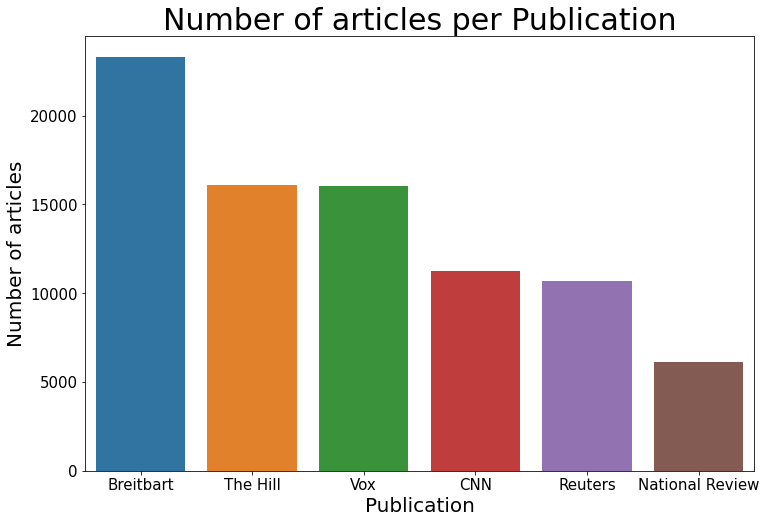

In [178]:
countplot(df, "Publication", order = df["Publication"].value_counts().index)

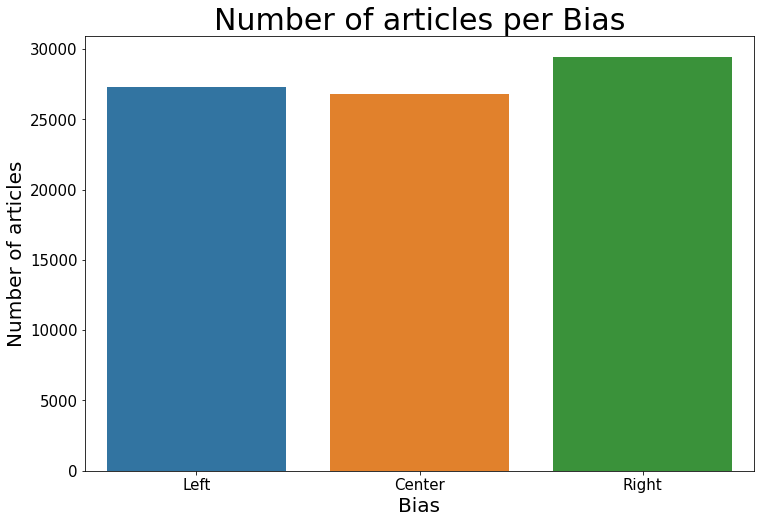

In [179]:
countplot(df, "Bias", order = ["Left", "Center", "Right"])

In [180]:
df_plot = df.groupby(['Publication', 'Bias']).size().reset_index().pivot(columns='Publication', index='Bias', values=0)

In [181]:
df_plot = df_plot.reindex(["Left", "Center", "Right"])

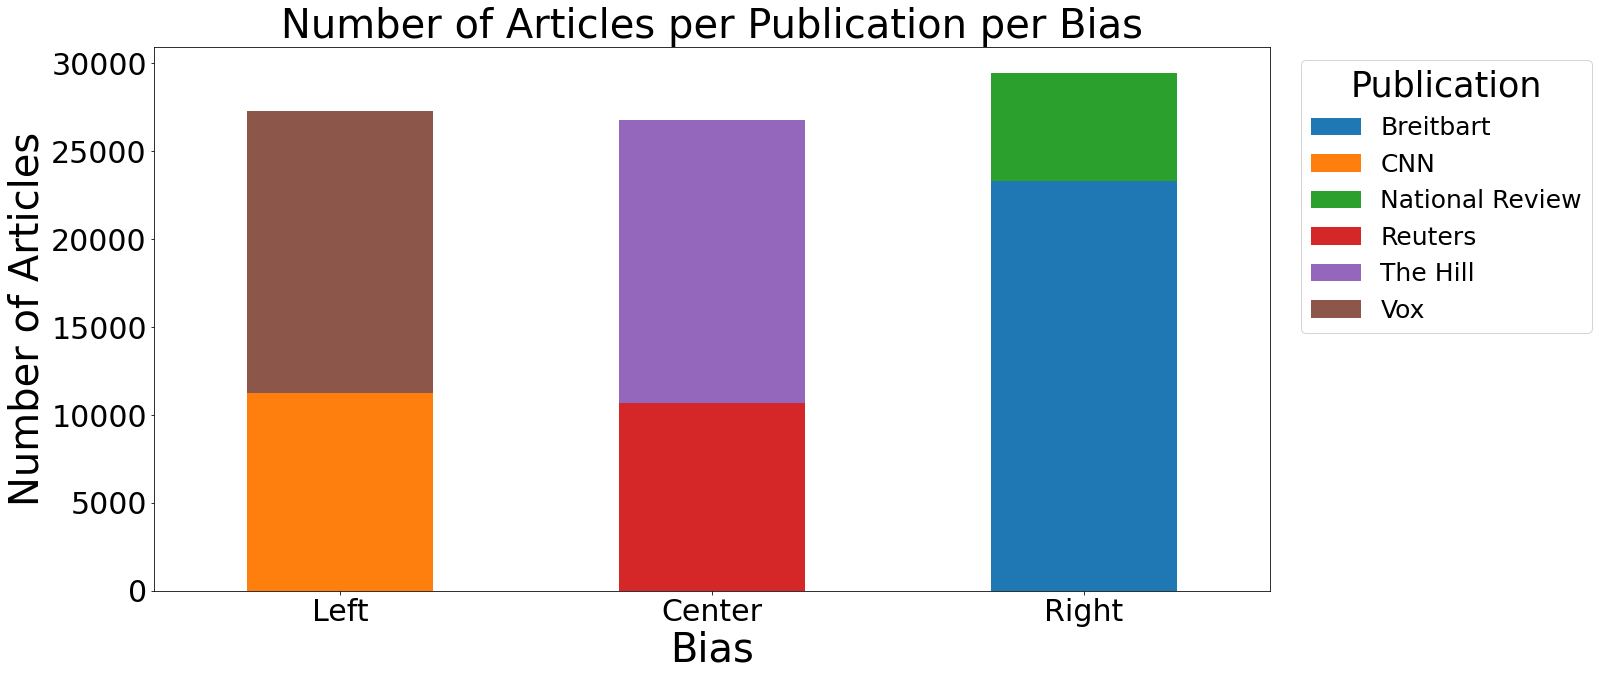

In [182]:
df_plot.plot(kind='bar', stacked=True, figsize=(20,10))
plt.xticks(rotation="horizontal", fontsize = 30)
plt.xlabel(xlabel = "Bias", fontsize = 40)
plt.yticks(rotation="horizontal", fontsize = 30)
plt.ylabel(ylabel = "Number of Articles", fontsize = 40)
plt.title(label= "Number of Articles per Publication per Bias", fontsize = 40)
plt.legend(bbox_to_anchor=(1.3, 1), loc="upper right", ncol=1, fontsize= 25, title = "Publication", title_fontsize= 35)
plt.show()

In [183]:
df

,Publication,Content,Bias,word_count,char_count,sentence_count
0,CNN,Istanbul (CNN) At least 39 people were killed ...,Left,1096,4625,43
1,CNN,Atlanta (CNN) This season’s College Football P...,Left,1114,4334,61
2,CNN,(CNN) Revelers on the United States’ west coa...,Left,980,4225,38
3,CNN,"West Palm Beach, Florida (CNN) Donald Trump s...",Left,709,2959,25
4,CNN,(CNN) Two small planes collided in Texas on S...,Left,97,450,5
...,...,...,...,...,...,...
85360,National Review,I first read Thomas Sowell in college — no ...,Right,954,4175,40
85361,National Review,Whether it’s celebrated according to the Grego...,Right,1356,6284,30
85362,National Review,Editor’s Note: This piece first appeared in th...,Right,846,3202,31
85363,National Review,Israel would seem to be in a disastrous positi...,Right,905,4014,45


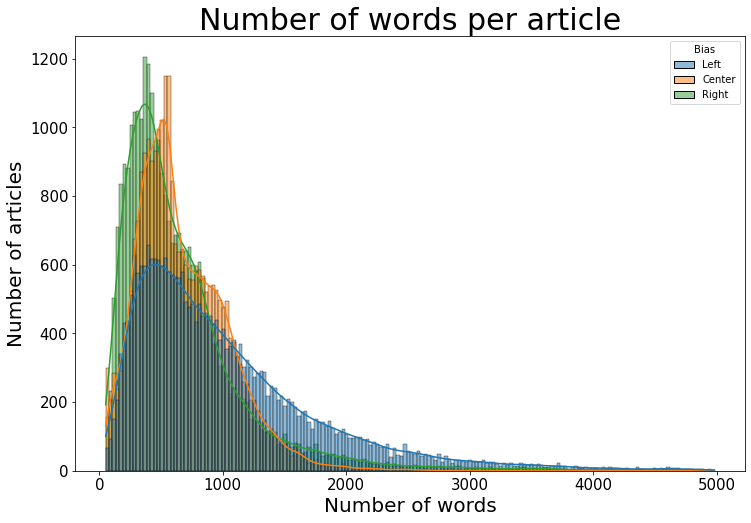

In [184]:
fig, ax = plt.subplots(figsize=(12,8))
hp = sns.histplot(data = df, x="word_count", hue = "Bias", kde=True)
ax.set_xlabel(xlabel = "Number of words", fontsize = 20)
ax.tick_params(axis='y', which='major', labelsize=15)
ax.tick_params(axis='x', which='major', labelsize=15)
ax.set_ylabel(ylabel = "Number of articles", fontsize = 20)
ax.set_title(f"Number of words per article", fontsize = 30)
plt.show()

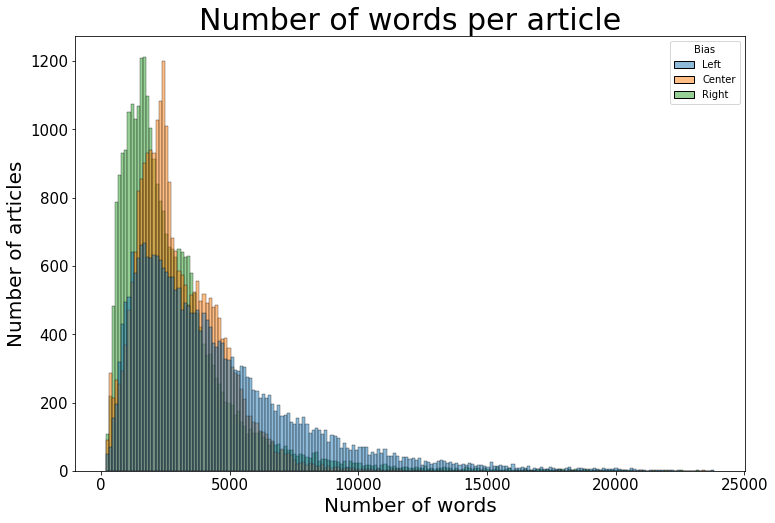

In [185]:
fig, ax = plt.subplots(figsize=(12,8))
sns.histplot(data = df, x="char_count", hue = "Bias")
ax.set_xlabel(xlabel = "Number of words", fontsize = 20)
ax.tick_params(axis='y', which='major', labelsize=15)
ax.tick_params(axis='x', which='major', labelsize=15)
ax.set_ylabel(ylabel = "Number of articles", fontsize = 20)
ax.set_title(f"Number of words per article", fontsize = 30)
plt.show()

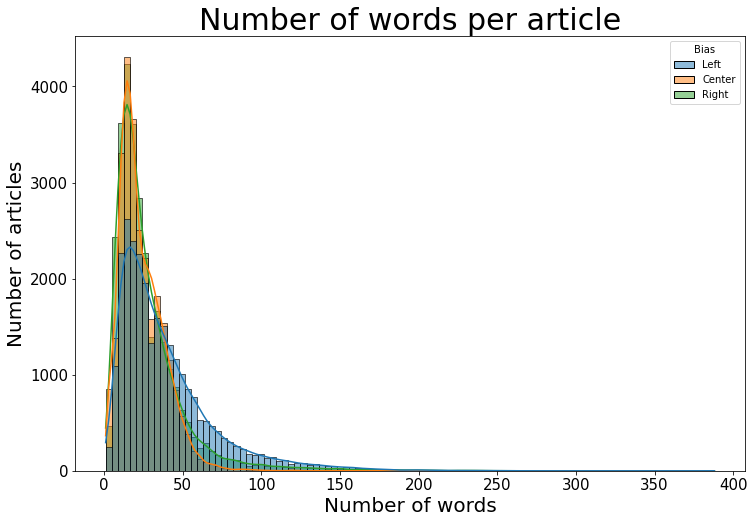

In [186]:
fig, ax = plt.subplots(figsize=(12,8))
sns.histplot(data = df, x="sentence_count", hue = "Bias", bins = 100, kde = True)
ax.set_xlabel(xlabel = "Number of words", fontsize = 20)
ax.tick_params(axis='y', which='major', labelsize=15)
ax.tick_params(axis='x', which='major', labelsize=15)
ax.set_ylabel(ylabel = "Number of articles", fontsize = 20)
ax.set_title(f"Number of words per article", fontsize = 30)
plt.show()

# Preprocessing Data

In [187]:
df

,Publication,Content,Bias,word_count,char_count,sentence_count
0,CNN,Istanbul (CNN) At least 39 people were killed ...,Left,1096,4625,43
1,CNN,Atlanta (CNN) This season’s College Football P...,Left,1114,4334,61
2,CNN,(CNN) Revelers on the United States’ west coa...,Left,980,4225,38
3,CNN,"West Palm Beach, Florida (CNN) Donald Trump s...",Left,709,2959,25
4,CNN,(CNN) Two small planes collided in Texas on S...,Left,97,450,5
...,...,...,...,...,...,...
85360,National Review,I first read Thomas Sowell in college — no ...,Right,954,4175,40
85361,National Review,Whether it’s celebrated according to the Grego...,Right,1356,6284,30
85362,National Review,Editor’s Note: This piece first appeared in th...,Right,846,3202,31
85363,National Review,Israel would seem to be in a disastrous positi...,Right,905,4014,45


In [188]:
#If we did a multi class
dict_sent = {'Left':0, 
             'Center':1,
             'Right':2}
df["num_bias"] = df["Bias"].map(dict_sent)

In [189]:
df.head()

,Publication,Content,Bias,word_count,char_count,sentence_count,num_bias
0,CNN,Istanbul (CNN) At least 39 people were killed ...,Left,1096,4625,43,0
1,CNN,Atlanta (CNN) This season’s College Football P...,Left,1114,4334,61,0
2,CNN,(CNN) Revelers on the United States’ west coa...,Left,980,4225,38,0
3,CNN,"West Palm Beach, Florida (CNN) Donald Trump s...",Left,709,2959,25,0
4,CNN,(CNN) Two small planes collided in Texas on S...,Left,97,450,5,0


In [190]:
df.iloc[45000:45005]

,Publication,Content,Bias,word_count,char_count,sentence_count,num_bias
45862,The Hill,China's commerce minister on Saturday warned t...,Center,241,1037,9,1
45863,The Hill,President TrumpDonald John TrumpO'Rourke: Trum...,Center,274,1311,8,1
45865,The Hill,With President Trump yet to fill top positions...,Center,1312,5370,44,1
45866,The Hill,When I started LGBTrump — the largest Gays for...,Center,1312,5701,46,1
45867,The Hill,A hacker group called “OurMine” breached Netfl...,Center,189,833,9,1


In [191]:
df.tail()

,Publication,Content,Bias,word_count,char_count,sentence_count,num_bias
85360,National Review,I first read Thomas Sowell in college — no ...,Right,954,4175,40,2
85361,National Review,Whether it’s celebrated according to the Grego...,Right,1356,6284,30,2
85362,National Review,Editor’s Note: This piece first appeared in th...,Right,846,3202,31,2
85363,National Review,Israel would seem to be in a disastrous positi...,Right,905,4014,45,2
85364,National Review,The year 2016 was a good one for books by men ...,Right,1039,4404,40,2


In [192]:
tokenizer = RegexpTokenizer(r"(?u)\b\w\w+\b")
lemma = WordNetLemmatizer()

In [193]:
source = list(df["Publication"].unique())
source = (map(lambda x: x.lower(), source))
source = list(source)
source

['cnn', 'vox', 'reuters', 'the hill', 'breitbart', 'national review']

In [194]:
stopwords_list = stopwords.words("english")
stopwords_list += string.punctuation
stopwords_list += source
print(stopwords_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [197]:
article = random.randint(0,df.shape[0])
test = df["Content"].iloc[article]
print(article)
test

81579


'British politicians do not often survive votes of no confidence in their leadership. For a prime minister, a loss in a confidence vote is typically the catalyst for a snap general election, if not a mortal wound. A leader, it is said, cannot carry on without the approval of the members of parliament he commands. Jeremy Corbyn, the leader of the Labour party, lost a confidence vote today. His party’s members of parliament voted by an enormous margin  —   172 to 40  —   to express no confidence in his role as Labour leader. This comes after the mass resignation of his shadow cabinet following the EU referendum, leaving the ranks of his supporters barely sufficient to constitute a new shadow cabinet. Corbyn, his critics in his party say, is a good man, a decent man, a man of deep conviction and dignity  —   but unfit to lead the Labour party. They point to his active undermining of the Remain campaign, his refusal to campaign alongside the Tories or even make a positive case for the Euro

In [198]:
test = test.lower()
test

'british politicians do not often survive votes of no confidence in their leadership. for a prime minister, a loss in a confidence vote is typically the catalyst for a snap general election, if not a mortal wound. a leader, it is said, cannot carry on without the approval of the members of parliament he commands. jeremy corbyn, the leader of the labour party, lost a confidence vote today. his party’s members of parliament voted by an enormous margin  —   172 to 40  —   to express no confidence in his role as labour leader. this comes after the mass resignation of his shadow cabinet following the eu referendum, leaving the ranks of his supporters barely sufficient to constitute a new shadow cabinet. corbyn, his critics in his party say, is a good man, a decent man, a man of deep conviction and dignity  —   but unfit to lead the labour party. they point to his active undermining of the remain campaign, his refusal to campaign alongside the tories or even make a positive case for the euro

In [199]:
pattern_mentions = "((@[a-zA-Z0-9_-]+)((?=\s+)|$|[!?.,-]))"
pattern_url = "(http\S+)"
pattern_views =  "((the views expressed by)([\s\S]*)$)"
pattern_thread = "((view the discussion thread.)([\s\S]*)$)"
pattern_pic = "((pic.)?twitter\.com\/[A-Za-z0-9_]{5,1000}(\?(\w+=\w+&?)*)?)"
pattern_num = "([\d.])"

In [200]:
test = re.sub(pattern_mentions,"", test)
test

'british politicians do not often survive votes of no confidence in their leadership. for a prime minister, a loss in a confidence vote is typically the catalyst for a snap general election, if not a mortal wound. a leader, it is said, cannot carry on without the approval of the members of parliament he commands. jeremy corbyn, the leader of the labour party, lost a confidence vote today. his party’s members of parliament voted by an enormous margin  —   172 to 40  —   to express no confidence in his role as labour leader. this comes after the mass resignation of his shadow cabinet following the eu referendum, leaving the ranks of his supporters barely sufficient to constitute a new shadow cabinet. corbyn, his critics in his party say, is a good man, a decent man, a man of deep conviction and dignity  —   but unfit to lead the labour party. they point to his active undermining of the remain campaign, his refusal to campaign alongside the tories or even make a positive case for the euro

In [201]:
test =  re.sub(pattern_url,"", test)
test

'british politicians do not often survive votes of no confidence in their leadership. for a prime minister, a loss in a confidence vote is typically the catalyst for a snap general election, if not a mortal wound. a leader, it is said, cannot carry on without the approval of the members of parliament he commands. jeremy corbyn, the leader of the labour party, lost a confidence vote today. his party’s members of parliament voted by an enormous margin  —   172 to 40  —   to express no confidence in his role as labour leader. this comes after the mass resignation of his shadow cabinet following the eu referendum, leaving the ranks of his supporters barely sufficient to constitute a new shadow cabinet. corbyn, his critics in his party say, is a good man, a decent man, a man of deep conviction and dignity  —   but unfit to lead the labour party. they point to his active undermining of the remain campaign, his refusal to campaign alongside the tories or even make a positive case for the euro

In [202]:
test =  re.sub(pattern_views,"", test)
test

'british politicians do not often survive votes of no confidence in their leadership. for a prime minister, a loss in a confidence vote is typically the catalyst for a snap general election, if not a mortal wound. a leader, it is said, cannot carry on without the approval of the members of parliament he commands. jeremy corbyn, the leader of the labour party, lost a confidence vote today. his party’s members of parliament voted by an enormous margin  —   172 to 40  —   to express no confidence in his role as labour leader. this comes after the mass resignation of his shadow cabinet following the eu referendum, leaving the ranks of his supporters barely sufficient to constitute a new shadow cabinet. corbyn, his critics in his party say, is a good man, a decent man, a man of deep conviction and dignity  —   but unfit to lead the labour party. they point to his active undermining of the remain campaign, his refusal to campaign alongside the tories or even make a positive case for the euro

In [203]:
test =  re.sub(pattern_thread,"", test)
test

'british politicians do not often survive votes of no confidence in their leadership. for a prime minister, a loss in a confidence vote is typically the catalyst for a snap general election, if not a mortal wound. a leader, it is said, cannot carry on without the approval of the members of parliament he commands. jeremy corbyn, the leader of the labour party, lost a confidence vote today. his party’s members of parliament voted by an enormous margin  —   172 to 40  —   to express no confidence in his role as labour leader. this comes after the mass resignation of his shadow cabinet following the eu referendum, leaving the ranks of his supporters barely sufficient to constitute a new shadow cabinet. corbyn, his critics in his party say, is a good man, a decent man, a man of deep conviction and dignity  —   but unfit to lead the labour party. they point to his active undermining of the remain campaign, his refusal to campaign alongside the tories or even make a positive case for the euro

In [204]:
test =  re.sub(pattern_pic,"", test)
test

'british politicians do not often survive votes of no confidence in their leadership. for a prime minister, a loss in a confidence vote is typically the catalyst for a snap general election, if not a mortal wound. a leader, it is said, cannot carry on without the approval of the members of parliament he commands. jeremy corbyn, the leader of the labour party, lost a confidence vote today. his party’s members of parliament voted by an enormous margin  —   172 to 40  —   to express no confidence in his role as labour leader. this comes after the mass resignation of his shadow cabinet following the eu referendum, leaving the ranks of his supporters barely sufficient to constitute a new shadow cabinet. corbyn, his critics in his party say, is a good man, a decent man, a man of deep conviction and dignity  —   but unfit to lead the labour party. they point to his active undermining of the remain campaign, his refusal to campaign alongside the tories or even make a positive case for the euro

In [205]:
test =  re.sub(pattern_num,"", test)
test

'british politicians do not often survive votes of no confidence in their leadership for a prime minister, a loss in a confidence vote is typically the catalyst for a snap general election, if not a mortal wound a leader, it is said, cannot carry on without the approval of the members of parliament he commands jeremy corbyn, the leader of the labour party, lost a confidence vote today his party’s members of parliament voted by an enormous margin  —    to   —   to express no confidence in his role as labour leader this comes after the mass resignation of his shadow cabinet following the eu referendum, leaving the ranks of his supporters barely sufficient to constitute a new shadow cabinet corbyn, his critics in his party say, is a good man, a decent man, a man of deep conviction and dignity  —   but unfit to lead the labour party they point to his active undermining of the remain campaign, his refusal to campaign alongside the tories or even make a positive case for the european union, 

In [206]:
test = tokenizer.tokenize(test)
test

['british',
 'politicians',
 'do',
 'not',
 'often',
 'survive',
 'votes',
 'of',
 'no',
 'confidence',
 'in',
 'their',
 'leadership',
 'for',
 'prime',
 'minister',
 'loss',
 'in',
 'confidence',
 'vote',
 'is',
 'typically',
 'the',
 'catalyst',
 'for',
 'snap',
 'general',
 'election',
 'if',
 'not',
 'mortal',
 'wound',
 'leader',
 'it',
 'is',
 'said',
 'cannot',
 'carry',
 'on',
 'without',
 'the',
 'approval',
 'of',
 'the',
 'members',
 'of',
 'parliament',
 'he',
 'commands',
 'jeremy',
 'corbyn',
 'the',
 'leader',
 'of',
 'the',
 'labour',
 'party',
 'lost',
 'confidence',
 'vote',
 'today',
 'his',
 'party',
 'members',
 'of',
 'parliament',
 'voted',
 'by',
 'an',
 'enormous',
 'margin',
 'to',
 'to',
 'express',
 'no',
 'confidence',
 'in',
 'his',
 'role',
 'as',
 'labour',
 'leader',
 'this',
 'comes',
 'after',
 'the',
 'mass',
 'resignation',
 'of',
 'his',
 'shadow',
 'cabinet',
 'following',
 'the',
 'eu',
 'referendum',
 'leaving',
 'the',
 'ranks',
 'of',
 'his',

In [207]:
stopwords_removed=[token for token in test if token not in stopwords_list]
print(str(" ".join(stopwords_removed)))

british politicians often survive votes confidence leadership prime minister loss confidence vote typically catalyst snap general election mortal wound leader said cannot carry without approval members parliament commands jeremy corbyn leader labour party lost confidence vote today party members parliament voted enormous margin express confidence role labour leader comes mass resignation shadow cabinet following eu referendum leaving ranks supporters barely sufficient constitute new shadow cabinet corbyn critics party say good man decent man man deep conviction dignity unfit lead labour party point active undermining remain campaign refusal campaign alongside tories even make positive case european union mass rebellion labour voters north england outside country urban areas defied party leadership vote en masse leave eu internal crisis facing labour party comes jeremy corbyn like politicians never never typical british politician especially typical party leader views party paramount ex

In [208]:
lemma_list = [lemma.lemmatize(token) for token in stopwords_removed]
print(str(" ".join(lemma_list)))

british politician often survive vote confidence leadership prime minister loss confidence vote typically catalyst snap general election mortal wound leader said cannot carry without approval member parliament command jeremy corbyn leader labour party lost confidence vote today party member parliament voted enormous margin express confidence role labour leader come mass resignation shadow cabinet following eu referendum leaving rank supporter barely sufficient constitute new shadow cabinet corbyn critic party say good man decent man man deep conviction dignity unfit lead labour party point active undermining remain campaign refusal campaign alongside tory even make positive case european union mass rebellion labour voter north england outside country urban area defied party leadership vote en masse leave eu internal crisis facing labour party come jeremy corbyn like politician never never typical british politician especially typical party leader view party paramount expected follow pa

In [209]:
df

,Publication,Content,Bias,word_count,char_count,sentence_count,num_bias
0,CNN,Istanbul (CNN) At least 39 people were killed ...,Left,1096,4625,43,0
1,CNN,Atlanta (CNN) This season’s College Football P...,Left,1114,4334,61,0
2,CNN,(CNN) Revelers on the United States’ west coa...,Left,980,4225,38,0
3,CNN,"West Palm Beach, Florida (CNN) Donald Trump s...",Left,709,2959,25,0
4,CNN,(CNN) Two small planes collided in Texas on S...,Left,97,450,5,0
...,...,...,...,...,...,...,...
85360,National Review,I first read Thomas Sowell in college — no ...,Right,954,4175,40,2
85361,National Review,Whether it’s celebrated according to the Grego...,Right,1356,6284,30,2
85362,National Review,Editor’s Note: This piece first appeared in th...,Right,846,3202,31,2
85363,National Review,Israel would seem to be in a disastrous positi...,Right,905,4014,45,2


In [210]:
#Instaiate needed objects
tokenizer = RegexpTokenizer(r"(?u)\w{3,}")
stopwords_list = stopwords_list
lemma = WordNetLemmatizer()

In [211]:
stopwords_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [212]:
pattern = "((@[a-zA-Z0-9_-]+)((?=\s+)|$|[!?.,-]))"
pattern1 =  "((the views expressed by)([\s\S]*)$)"
pattern2 = "((view the discussion thread.)([\s\S]*)$)"
pattern3 = "((pic.)?twitter\.com\/[A-Za-z0-9_]{5,1000}(\?(\w+=\w+&?)*)?)"
pattern4 = "([\d.])"
pattern5 = "(http\S+)"

In [213]:
def preprocess(content):
    #Turn all the tokens lowercase
    content = content.lower()
    #rmove necessary item from content (see above)
    content = re.sub(pattern, " ", str(content))
    content = re.sub(pattern1, " ", str(content))
    content = re.sub(pattern2, " ", str(content))
    content = re.sub(pattern3, " ", str(content))
    content = re.sub(pattern4, " ", str(content))
    content = re.sub(pattern5, " ", str(content))
    #Only include words with 3 or more characters
    token_list = tokenizer.tokenize(content)
    #Remove stopwords
    stopwords_removed=[token for token in token_list if token not in stopwords_list]
    #Lemmatize the remaining word tokens
    lemma_list = [lemma.lemmatize(token) for token in stopwords_removed]
    #Turn the lemma list into a string for the Vectorizer
    cleaned_string = " ".join(lemma_list) 
    return str(cleaned_string)

In [214]:
df["Content"].iloc[50600]

'Rep. Michael Turner (R-Ohio) in an interview broadcast Sunday slammed the intelligence community for information leaked to U.S. newspapers, saying the leaks "have to stop." "We cannot have trust in an intelligence community where their main method of communicating is under the masthead of the Washington Post and the New York Times,” Turner said during an interview with John Catsimatidis on 970 AM in New York. "These leaks have to stop. They are certainly undermining the credibility of the intelligence community." The newspapers have both extensively covered Russia’s information campaign aimed at interfering in the U.S. presidential election. The Post also broke the story that ultimately lead to the resignation of President TrumpDonald John TrumpO\'Rourke: Trump driving global, U.S. economy into recession Manchin: Trump has \'golden opportunity\' on gun reforms Objections to Trump\'s new immigration rule wildly exaggerated MORE’s first national security adviser, retired Lt. Gen. Michae

In [215]:
#Sanity check on data
preprocess(df["Content"].iloc[50600])

'rep michael turner ohio interview broadcast sunday slammed intelligence community information leaked newspaper saying leak stop cannot trust intelligence community main method communicating masthead washington post new york time turner said interview john catsimatidis new york leak stop certainly undermining credibility intelligence community newspaper extensively covered russia information campaign aimed interfering presidential election post also broke story ultimately lead resignation president trumpdonald john trumpo rourke trump driving global economy recession manchin trump golden opportunity gun reform objection trump new immigration rule wildly exaggerated first national security adviser retired gen michael flynn turner argued interview russia ultimately affect result election assessment intelligence community russia took action step affect outcome election certainly cause doubt turner said everyone agrees russia ability affect outcome voting outcome electorate people decision

In [216]:
df["processed_content"] =  df["Content"].apply(lambda x: preprocess(x))

In [217]:
df

,Publication,Content,Bias,word_count,char_count,sentence_count,num_bias,processed_content
0,CNN,Istanbul (CNN) At least 39 people were killed ...,Left,1096,4625,43,0,istanbul least people killed least wounded att...
1,CNN,Atlanta (CNN) This season’s College Football P...,Left,1114,4334,61,0,atlanta season college football playoff center...
2,CNN,(CNN) Revelers on the United States’ west coa...,Left,980,4225,38,0,reveler united state west coast cheered advent...
3,CNN,"West Palm Beach, Florida (CNN) Donald Trump s...",Left,709,2959,25,0,west palm beach florida donald trump said satu...
4,CNN,(CNN) Two small planes collided in Texas on S...,Left,97,450,5,0,two small plane collided texas saturday killin...
...,...,...,...,...,...,...,...,...
85360,National Review,I first read Thomas Sowell in college — no ...,Right,954,4175,40,2,first read thomas sowell college thanks colleg...
85361,National Review,Whether it’s celebrated according to the Grego...,Right,1356,6284,30,2,whether celebrated according gregorian julian ...
85362,National Review,Editor’s Note: This piece first appeared in th...,Right,846,3202,31,2,editor note piece first appeared april issue n...
85363,National Review,Israel would seem to be in a disastrous positi...,Right,905,4014,45,2,israel would seem disastrous position given in...


In [218]:
df['pro_word_count'] = df["processed_content"].apply(lambda x: len(nltk.word_tokenize(str(x))) )
df['pro_char_count'] = df["processed_content"].apply(lambda x: sum(len(word) for word in nltk.word_tokenize(str(x))) )
df['pro_sentence_count'] = df["processed_content"].apply(lambda x: len(nltk.sent_tokenize(str(x))))

In [219]:
df

,Publication,Content,Bias,word_count,char_count,sentence_count,num_bias,processed_content,pro_word_count,pro_char_count,pro_sentence_count
0,CNN,Istanbul (CNN) At least 39 people were killed ...,Left,1096,4625,43,0,istanbul least people killed least wounded att...,540,3346,1
1,CNN,Atlanta (CNN) This season’s College Football P...,Left,1114,4334,61,0,atlanta season college football playoff center...,495,2934,1
2,CNN,(CNN) Revelers on the United States’ west coa...,Left,980,4225,38,0,reveler united state west coast cheered advent...,498,3078,1
3,CNN,"West Palm Beach, Florida (CNN) Donald Trump s...",Left,709,2959,25,0,west palm beach florida donald trump said satu...,321,2093,1
4,CNN,(CNN) Two small planes collided in Texas on S...,Left,97,450,5,0,two small plane collided texas saturday killin...,55,346,1
...,...,...,...,...,...,...,...,...,...,...,...
85360,National Review,I first read Thomas Sowell in college — no ...,Right,954,4175,40,2,first read thomas sowell college thanks colleg...,426,2943,1
85361,National Review,Whether it’s celebrated according to the Grego...,Right,1356,6284,30,2,whether celebrated according gregorian julian ...,639,4442,1
85362,National Review,Editor’s Note: This piece first appeared in th...,Right,846,3202,31,2,editor note piece first appeared april issue n...,375,2215,1
85363,National Review,Israel would seem to be in a disastrous positi...,Right,905,4014,45,2,israel would seem disastrous position given in...,446,2902,1


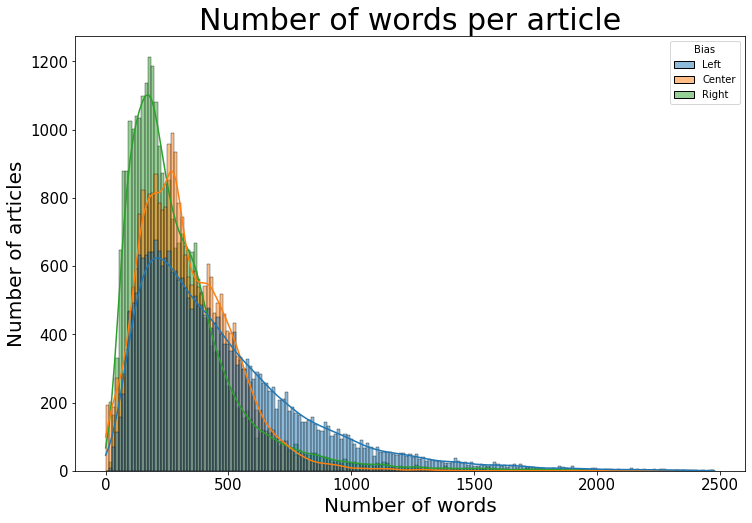

In [220]:
fig, ax = plt.subplots(figsize=(12,8))
hp = sns.histplot(data = df, x="pro_word_count", hue = "Bias", kde=True)
ax.set_xlabel(xlabel = "Number of words", fontsize = 20)
ax.tick_params(axis='y', which='major', labelsize=15)
ax.tick_params(axis='x', which='major', labelsize=15)
ax.set_ylabel(ylabel = "Number of articles", fontsize = 20)
ax.set_title(f"Number of words per processed article", fontsize = 30)
plt.show()

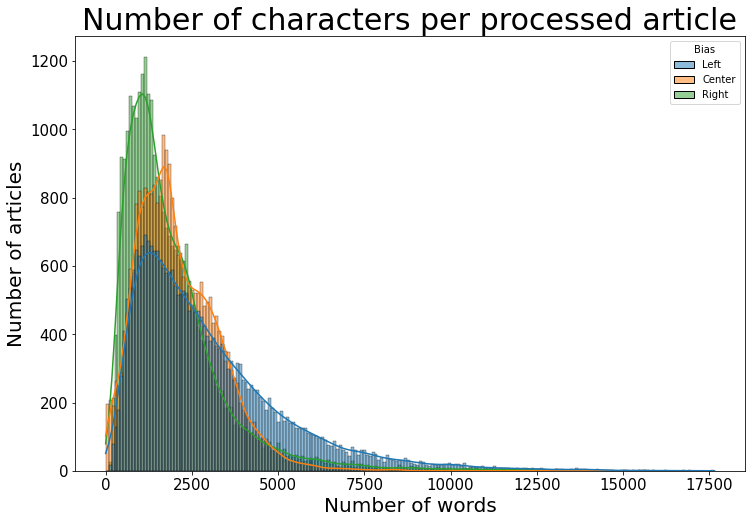

In [223]:
fig, ax = plt.subplots(figsize=(12,8))
hp = sns.histplot(data = df, x="pro_char_count", hue = "Bias", kde=True)
ax.set_xlabel(xlabel = "Number of words", fontsize = 20)
ax.tick_params(axis='y', which='major', labelsize=15)
ax.tick_params(axis='x', which='major', labelsize=15)
ax.set_ylabel(ylabel = "Number of articles", fontsize = 20)
ax.set_title(f"Number of characters per processed article", fontsize = 30)
plt.show()

In [65]:
df.to_pickle("../data/processed.pkl")